In [78]:
import numpy as np
import pandas as pd 
import os

from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%matplotlib inline

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elmaxuno/marketing-log")

print("Path to dataset files:", path)

Path to dataset files: /Users/vadimoblog/.cache/kagglehub/datasets/elmaxuno/marketing-log/versions/1


In [61]:

visits = pd.read_csv(f'{path}/marketing_log.csv',sep="\t")

/var/folders/yg/36smwq7n3lj7_wgryt2vcw3r0000gn/T/ipykernel_47563/2999461930.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  visits = pd.read_csv(f'{path}/marketing_log.csv',sep="\t")


In [62]:
visits['date'] = pd.to_datetime(visits['date'], format = '%Y-%m-%d')

visits.sort_values('date',inplace=True)

visits.reset_index(drop=True,inplace=True)

print(visits.shape)
visits.head()

(903653, 5)


,date,fullVisitorId,browser,deviceCategory,transactionRevenue
0,2016-08-01,1492602573213666603,Chrome,desktop,NaN
1,2016-08-01,7394165545362887055,Chrome,desktop,NaN
2,2016-08-01,6107229716178617930,Chrome,desktop,NaN
3,2016-08-01,9459384188253198762,Chrome,desktop,NaN
4,2016-08-01,4052177266351383392,Safari,desktop,NaN


In [63]:
day = visits.groupby('date').agg({'fullVisitorId':'nunique'})

day.head()

,fullVisitorId
date,
2016-08-01,1569
2016-08-02,1961
2016-08-03,2657
2016-08-04,2947
2016-08-05,2492


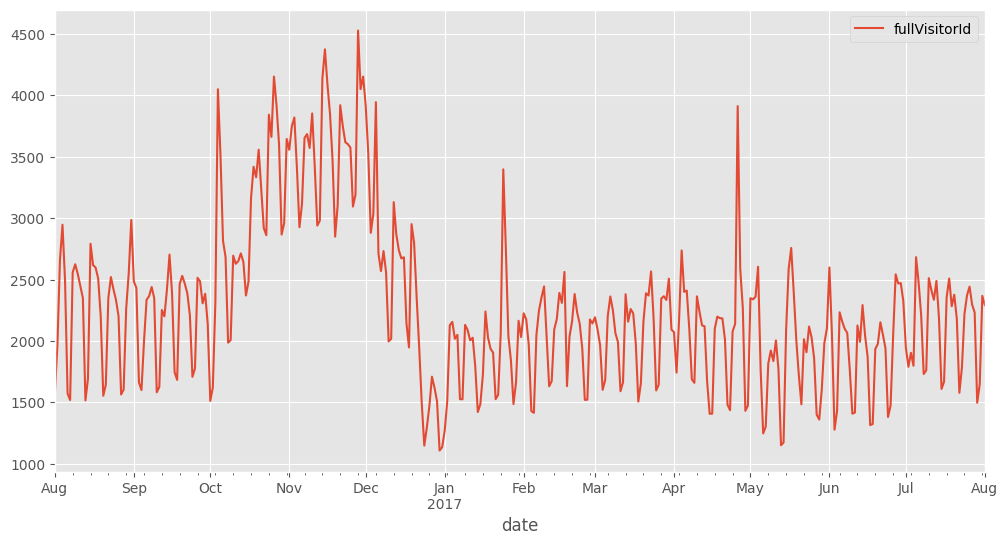

In [64]:
day.sort_index().plot(figsize=(12,6));

In [65]:
first_visit = visits.groupby('fullVisitorId').agg({'date':'min'})
first_visit.columns = ['firstVisit']

visits = visits.join(first_visit, on='fullVisitorId')
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue,firstVisit
0,2016-08-01,1492602573213666603,Chrome,desktop,NaN,2016-08-01
1,2016-08-01,7394165545362887055,Chrome,desktop,NaN,2016-08-01
2,2016-08-01,6107229716178617930,Chrome,desktop,NaN,2016-08-01
3,2016-08-01,9459384188253198762,Chrome,desktop,NaN,2016-08-01
4,2016-08-01,4052177266351383392,Safari,desktop,NaN,2016-08-01


In [66]:
visits['daysFromFirstVisit'] = (visits.date - visits.firstVisit).apply(lambda w: w.days)

<Axes: >

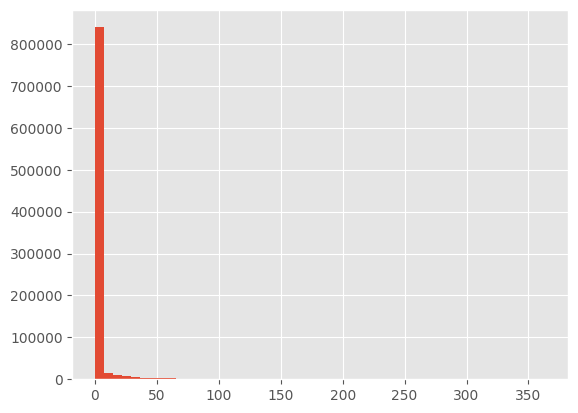

In [67]:
visits['daysFromFirstVisit'].hist(bins=50)

<Axes: >

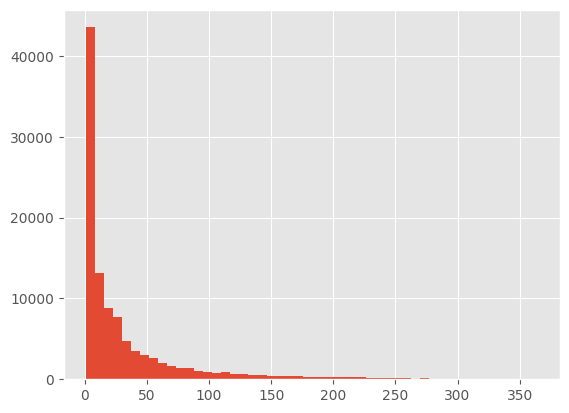

In [68]:
visits[visits['daysFromFirstVisit'] > 0]['daysFromFirstVisit'].hist(bins=50)

In [70]:
firstVisits = visits.groupby(['firstVisit','fullVisitorId']).agg({'daysFromFirstVisit':'max'}).reset_index()
firstVisits.head()

,firstVisit,fullVisitorId,daysFromFirstVisit
0,2016-08-01,722514342430295,0
1,2016-08-01,1747219368939605,0
2,2016-08-01,2855959112934473,117
3,2016-08-01,3651776577235999,0
4,2016-08-01,4401382581757781,0


In [73]:
retention = (
    firstVisits
    .groupby('firstVisit')
    .agg(
        success=('daysFromFirstVisit', lambda w: (w >= 7).sum()),
        total=('daysFromFirstVisit', 'count'),
    )
)

retention.head()

,success,total
firstVisit,,
2016-08-01,186,1569
2016-08-02,171,1961
2016-08-03,227,2594
2016-08-04,168,2797
2016-08-05,158,2446


<Axes: xlabel='firstVisit'>

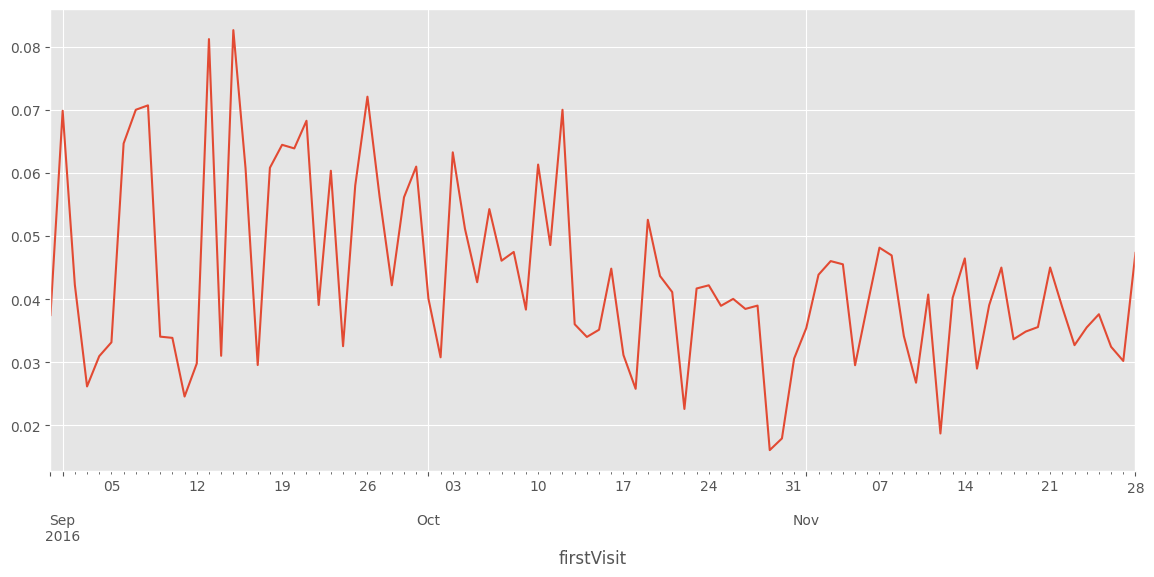

In [74]:
retention['retention'] = retention['success']/retention['total']
retention['retention'][30:120].plot(figsize=(14,6))

In [125]:
alpha = 0.05

retention['se'] = np.sqrt(retention['retention'] * (1- retention['retention'])/retention['retention'].shape[0])

q = stats.norm.ppf(1-alpha/2)
retention['left'] = retention['retention'] - q * retention['se']
retention['right'] = retention['retention'] + q * retention['se']

retention.head()

,success,total,retention,se,left,right
firstVisit,,,,,,
2016-08-01,186,1569,0.118547,0.016897,0.085430,0.151664
2016-08-02,171,1961,0.087200,0.014747,0.058297,0.116104
2016-08-03,227,2594,0.087510,0.014771,0.058560,0.116460
2016-08-04,168,2797,0.060064,0.012420,0.035722,0.084407
2016-08-05,158,2446,0.064595,0.012849,0.039412,0.089778


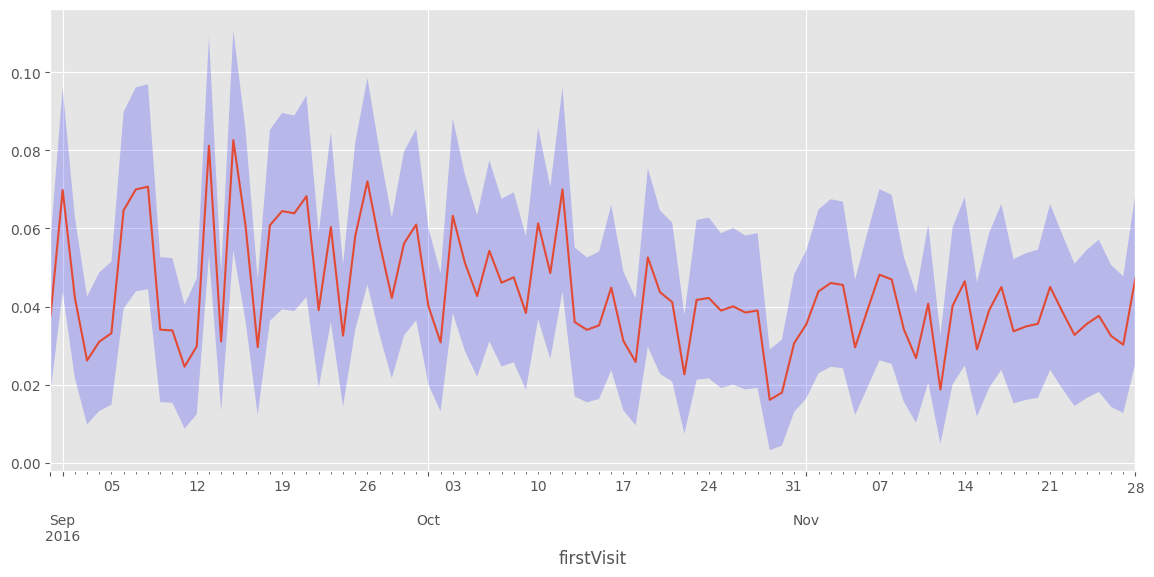

In [126]:
df = retention[30:120]
df['retention'].plot(figsize=(14,6))
plt.fill_between(df.index, df['left'],df['right'], facecolor = 'blue', alpha=0.2)
plt.show()

In [127]:
100*(1 - visits['transactionRevenue'].isnull().sum()/visits.shape[0])

1.2742723147048718

In [128]:
visits['month'] = visits['date'].apply(lambda w: w.strftime('%Y-%m'))

purchases = visits.dropna(subset=['transactionRevenue'])
purchases.shape

(11515, 8)

<Axes: >

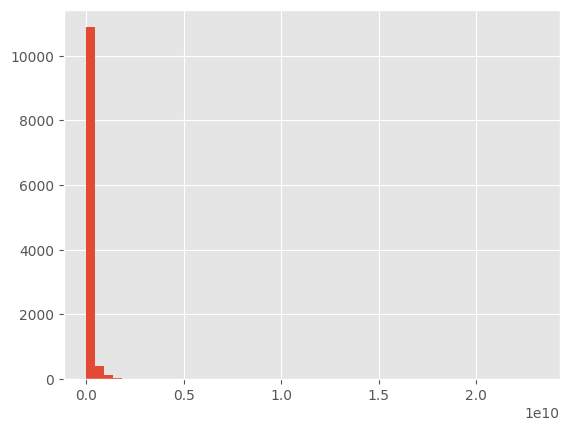

In [129]:
purchases['transactionRevenue'].hist(bins=50)

In [130]:
q99 = purchases['transactionRevenue'].quantile(0.99)
q99

1269774600.000006

<Axes: >

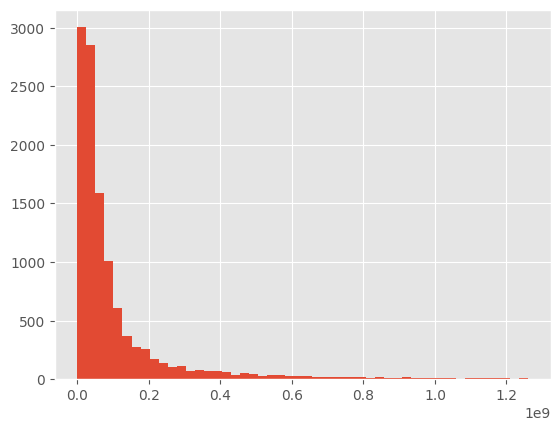

In [131]:
purchases = purchases[purchases['transactionRevenue'] < q99]
purchases['transactionRevenue'].hist(bins=50)

In [135]:
datePurchases = (
    visits
    .groupby('month')
    .agg(
        rpu=('transactionRevenue', 'mean'),
        count=('transactionRevenue', 'count'),
        se = ('transactionRevenue', 'std')
    )
).reset_index()

In [136]:
datePurchases.head()

,month,rpu,count,se
0,2016-08,1.382186e+08,1119,2.664052e+08
1,2016-09,1.467186e+08,859,5.890688e+08
2,2016-10,1.299645e+08,872,2.523772e+08
3,2016-11,1.295037e+08,919,2.737449e+08
4,2016-12,1.107942e+08,1395,3.020593e+08


In [141]:
alpha = 0.05 

q = stats.norm.ppf(1 - alpha/2)
datePurchases['left'] = datePurchases['rpu'] - q * datePurchases['se']
datePurchases['right'] = datePurchases['rpu'] + q * datePurchases['se']

datePurchases.tail()

,month,rpu,count,se,left,right
8,2017-04,1.711086e+08,928,8.990373e+08,-1.590972e+09,1.933189e+09
9,2017-05,1.091583e+08,1115,2.553799e+08,-3.913771e+08,6.096937e+08
10,2017-06,1.285090e+08,946,3.741667e+08,-6.048443e+08,8.618622e+08
11,2017-07,1.207558e+08,1031,4.093907e+08,-6.816352e+08,9.231469e+08
12,2017-08,1.931381e+08,43,4.787008e+08,-7.450981e+08,1.131374e+09


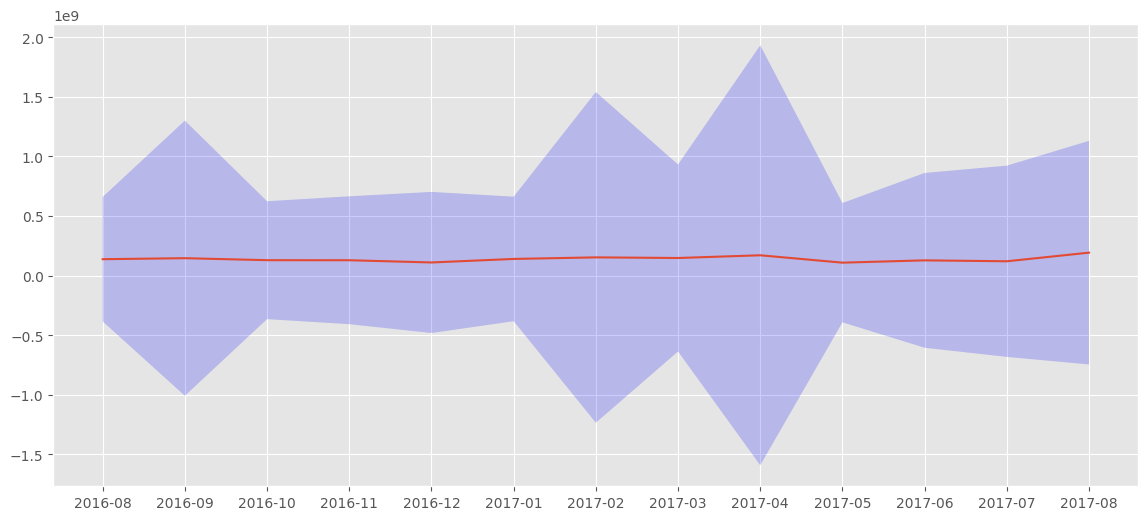

In [142]:
datePurchases['rpu'].plot(figsize=(14,6))
plt.fill_between(datePurchases['month'],datePurchases['left'],datePurchases['right'],facecolor='blue',alpha=0.2, interpolate=True)